# Общее описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Цель\
Предсказать вероятность покупки в течение 90 дней

Данные\
apparel-purchases\
история покупок\
● client_id идентификатор пользователя\
● quantity количество товаров в заказе\
● price цена товара\
● category_ids вложенные категории, к которым относится товар\
● date дата покупки\
● message_id идентификатор сообщения из рассылки\
apparel-messages\
история рекламных рассылок\
● bulk_campaign_id идентификатор рекламной кампании\
● client_id идентификатор пользователя\
● message_id идентификатор сообщений\
● event тип действия\
● channel канал рассылки\
● date дата рассылки\
● created_at точное время создания сообщения\

apparel-target_binary\
совершит ли клиент покупку в течение следующих 90 дней\
● client_id идентификатор пользователя\
● target целевой признак

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import uuid
from datetime import datetime
from collections import Counter
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
#sclearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error, \
                            precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from category_encoders import TargetEncoder
#phik
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix
#stat
from scipy.stats import ttest_ind

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)     
pd.set_option('display.width', None)        
pd.set_option('display.max_colwidth', None) 

# Загрузка данных

In [3]:
try:
    messages = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_2\apparel-messages.csv")
    purchases = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_2\apparel-purchases.csv")
    target_binary = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_2\apparel-target_binary.csv")
    full_campaign_daily_event = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_2\full_campaign_daily_event.csv")
    full_campaign_daily_event_channel = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_2\full_campaign_daily_event_channel.csv")
except Exception as e:
    print(e)

## Предварительный общий обзор

In [4]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [5]:
messages.shape

(12739798, 7)

In [6]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [7]:
purchases.shape

(202208, 6)

In [8]:
target_binary.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [9]:
target_binary.shape

(49849, 2)

In [10]:
full_campaign_daily_event.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [11]:
full_campaign_daily_event.shape

(131072, 24)

In [12]:
full_campaign_daily_event_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
full_campaign_daily_event_channel.shape

(131072, 36)

**Вывод:**\
Выполнен предварительный обзор данных. Данные соответствуют описанию.

# Обзор данных

In [14]:
# функция для обзора данных
def data_overview(df, discret_values=20):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 1. Выводим первые 5 строк
    print("Первых 5 строк данных:")
    display(df.head())

    # 2. Информация о DataFrame
    print("\nИнформация о DataFrame:")
    df.info()

    # 3. Количество пропусков
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Пропуски (шт)': missing_data,
        'Пропуски (%)': missing_percent
    })
    missing_df = missing_df[missing_df['Пропуски (шт)'] > 0]
    print("\nКоличество пропусков (в шт и в %):")
    display(missing_df.style.background_gradient(cmap="YlOrRd"))

    # 4. Количество явных дубликатов
    try:
        duplicates_count = df.duplicated().sum()
        print(f"\nКоличество явных дубликатов: {duplicates_count}")
    except TypeError:
        # Преобразуем все элементы в строку (не изменяя сам df!)
        df_str = df.applymap(lambda x: str(x) if isinstance(x, (list, dict, set)) else x)
        duplicates_count = df_str.duplicated().sum()
        print(f"\nКоличество явных дубликатов (с преобразованием в строки): {duplicates_count}")

    # 5. Уникальные значения по нечисловым полям
    non_numeric_cols = df.select_dtypes(exclude=["number", "datetime"])
    non_list_cols = [
        col for col in non_numeric_cols.columns
        if not df[col].apply(lambda x: isinstance(x, (list, dict, set))).any()]
    non_numeric_cols = df[non_list_cols]
    print("\nУникальные значения по нечисловым полям:")
    for col in non_numeric_cols.columns:
        unique_values = non_numeric_cols[col].unique()
        print(f"{col}: {unique_values[:10]}{'...' if len(unique_values) > 10 else ''}")
        try:
            cnt = df[col].nunique()
            print(f"Кол-во уникальных значений: {cnt}")
        except TypeError:
            print("Кол-во уникальных значений: невозможно определить (нехэшируемые объекты)")
        print('')

    # 6. Минимальное и максимальное значение для полей с датами
    date_cols = df.select_dtypes(include=["datetime"])
    if not date_cols.empty:
        print("\nМинимальные и максимальные значения для полей с датами:")
        for col in date_cols.columns:
            print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")

    # 7. Описательная статистика, исключая поля с 'id'
    numeric_cols = df.select_dtypes(include=["number"]).columns
    numeric_cols_no_id = [col for col in numeric_cols if 'id' not in col.lower()]
    if numeric_cols_no_id:
        print("\nОписательная статистика для числовых полей (без 'id'):")
        display(df[numeric_cols_no_id].describe())
    else:
        print("\nНет числовых полей без 'id' для описательной статистики.")

    # 8. Определение типа признака и построение графиков
    if numeric_cols_no_id:
        for col in numeric_cols_no_id:
            unique_values = df[col].nunique()
            if unique_values <= discret_values:  # Дискретный признак
                print(f"\nДискретный признак: {col}")
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                sns.countplot(data=df, x=col, order=df[col].value_counts().index,  ax=axes[0])
                axes[0].set_title(f"Столбчатая диаграмма: {col}")
                axes[0].tick_params(axis='x', rotation=45)
                sns.boxplot(x=df[col], ax=axes[1])
                axes[1].set_title(f"Boxplot: {col}")
                plt.tight_layout()
                plt.show()
            else:  # Непрерывный признак
                print(f"\nНепрерывный признак: {col}")
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                sns.histplot(df[col].dropna(), ax=axes[0], kde=True)
                axes[0].set_title(f"Гистограмма: {col}")
                sns.boxplot(x=df[col], ax=axes[1])
                axes[1].set_title(f"Boxplot: {col}")
                plt.tight_layout()
                plt.show()
    else:
        print("\nНет числовых полей без 'id' для построения графиков.")

## Сообщения

In [15]:
data_overview(messages)

Первых 5 строк данных:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)



Количество явных дубликатов: 48610

Уникальные значения по нечисловым полям:
message_id: ['1515915625626736623-4439-6283415ac07ea'
 '1515915625490086521-4439-62834150016dd'
 '1515915625553578558-4439-6283415b36b4f'
 '1515915625471518311-4439-628341570c133'
 '1515915625594606468-4439-6283411f277fc'
 '1515915625491810918-4439-6283411d9d299'
 '1515915625474219766-4439-628341212233a'
 '1515915625566741491-4439-6283412871599'
 '1515915625468091591-4439-628341501ed02'
 '1515915625580186302-4439-6283414fdd0af']...
Кол-во уникальных значений: 9061667

event: ['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain']...
Кол-во уникальных значений: 11

channel: ['email' 'mobile_push']
Кол-во уникальных значений: 2

date: ['2022-05-19' '2022-05-20' '2022-05-21' '2022-05-22' '2022-05-23'
 '2022-05-24' '2022-05-25' '2022-05-26' '2022-05-27' '2022-05-28']...
Кол-во уникальных значений: 638

created_at: ['2022-05-19 00:14:20' '2022-05-19 00:39:34'

**Вывод:**\
Пропуски в данных не обнаружены.\
Обнаружены явные дубликаты, неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.

## Покупки

Первых 5 строк данных:


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)



Количество явных дубликатов: 73020

Уникальные значения по нечисловым полям:
category_ids: ["['4', '28', '57', '431']" "['4', '28', '244', '432']"
 "['4', '28', '49', '413']" "['2', '18', '258', '441']"
 "['2', '18', '341', '1311']" "['2', '18', '123', '451']"
 "['5562', '5631', '5549', '667']" "['5562', '5630', '5649', '678']"
 "['4', '27', '350', '1392']" "['4', '28', '44', '490']"]...
Кол-во уникальных значений: 933

date: ['2022-05-16' '2022-05-17' '2022-05-18' '2022-05-19' '2022-05-20'
 '2022-05-21' '2022-05-22' '2022-05-23' '2022-05-24' '2022-05-25']...
Кол-во уникальных значений: 642

message_id: ['1515915625468169594-4301-627b661e9736d'
 '1515915625471138230-4437-6282242f27843'
 '1515915625471640575-4301-627b661b67ac3'
 '1515915625490211585-4301-627b661843283'
 '1515915625490739153-4172-626b943cc789b'
 '1515915625491478747-4273-6274ceb769d59'
 '1515915625491651493-4437-6282242f2a9e2'
 '1515915625491757718-4301-627b661681560'
 '1515915625491869271-2090-61a72488d6a0f'
 '15159156

,quantity,price
count,202208.000000,202208.000000
mean,1.006483,1193.301516
std,0.184384,1342.252664
min,1.000000,1.000000
25%,1.000000,352.000000
50%,1.000000,987.000000
75%,1.000000,1699.000000
max,30.000000,85499.000000



Дискретный признак: quantity


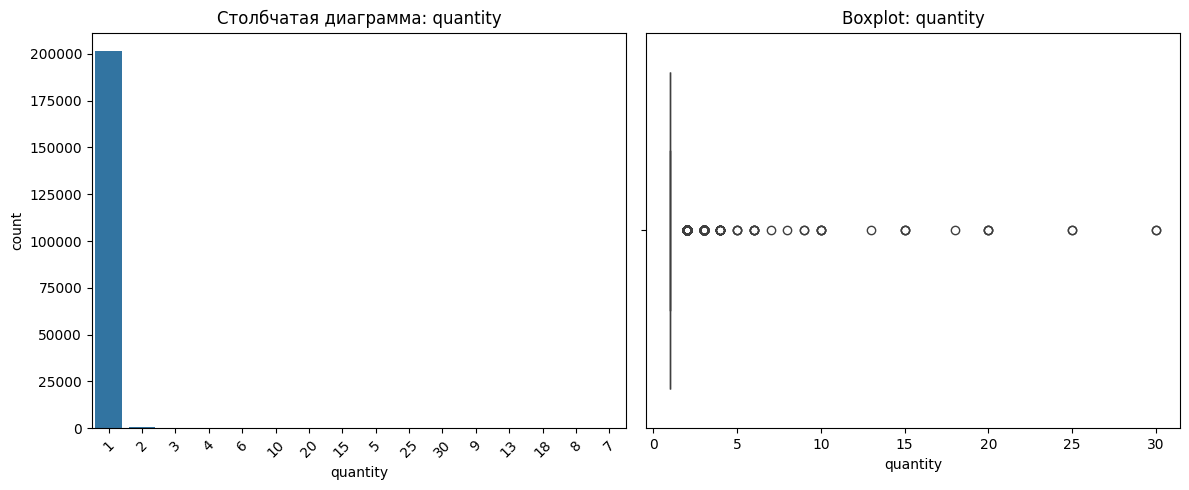


Непрерывный признак: price


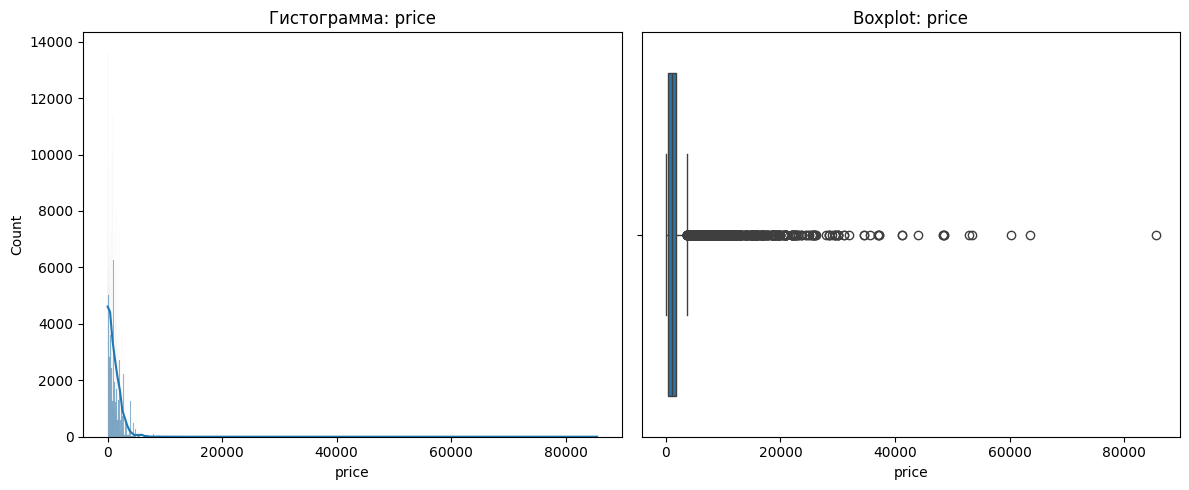

In [16]:
data_overview(purchases)

**Вывод:**\
Пропуски в данных не обнаружены.\
Обнаружены явные дубликаты, неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.

## Целевой признак

Первых 5 строк данных:


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)



Количество явных дубликатов: 0

Уникальные значения по нечисловым полям:

Описательная статистика для числовых полей (без 'id'):


,target
count,49849.000000
mean,0.019278
std,0.137503
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Дискретный признак: target


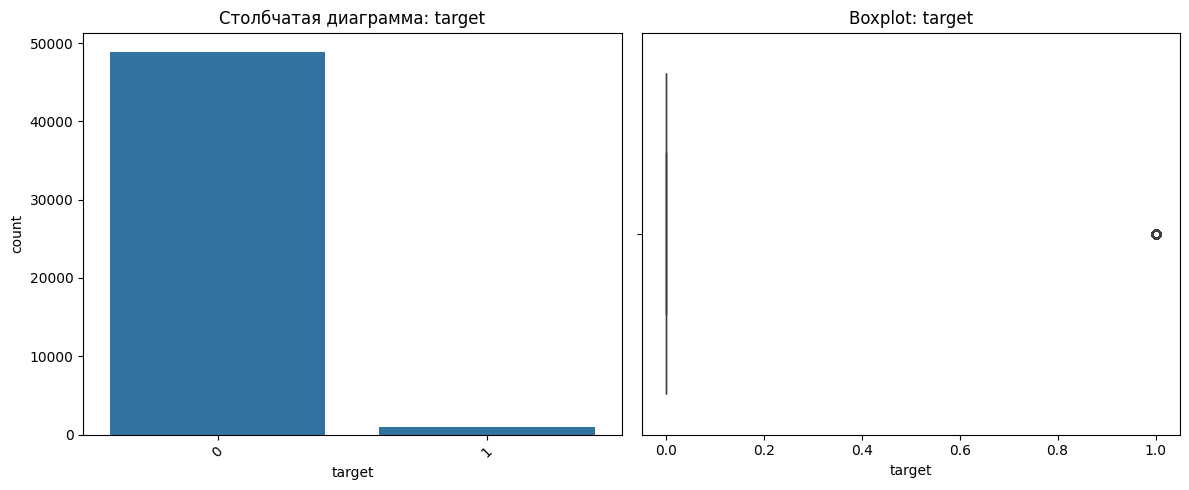

In [17]:
data_overview(target_binary)

**Вывод:**\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнаружены.\
Явные и неявные дубликаты не обнаружены.\
Наблюдается дисбаланс классов. 

## Общий вывод

*Сообщения:*\
Пропуски в данных не обнаружены.\
Обнаружены явные дубликаты, неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.

*Покупки:*\
Пропуски в данных не обнаружены.\
Обнаружены явные дубликаты, неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.

*Целевой признак:*\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнаружены.\
Явные и неявные дубликаты не обнаружены.\
Наблюдается дисбаланс классов.

# Предобработка данных

## Сообщения

### Преобразование типов данных

Преобразуем поля с датами в соответствующий тип данных:

In [18]:
date_columns = ['date', 'created_at']

for col in date_columns:
    messages[col] = pd.to_datetime(messages[col], errors='coerce')

### Обработка дубликатов

Удалим явные дубликаты:

In [19]:
messages = messages.drop_duplicates().reset_index(drop=True)

In [20]:
# проверка результата удаления
messages.duplicated().sum()

0

In [21]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Вывод:\
Выполнено преобразование типа данных в полях с датами.\
Удалены явные дубликаты.

## Покупки

### Преобразование типов данных

In [22]:
purchases['date'] = pd.to_datetime(purchases['date'], errors='coerce')

Проверим за какой период присутствую данные в датасете:

### Обработка дубликатов

Удалим явняе дубликаты:

In [23]:
purchases = purchases.drop_duplicates().reset_index(drop=True)

In [24]:
# проверим результат удаления
purchases.duplicated().sum()

0

### Проверка аномальных значений

In [25]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     129188 non-null  int64         
 1   quantity      129188 non-null  int64         
 2   price         129188 non-null  float64       
 3   category_ids  129188 non-null  object        
 4   date          129188 non-null  datetime64[ns]
 5   message_id    129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.9+ MB


In [26]:
np.percentile(purchases['quantity'], [95, 99])

array([1., 1.])

Менее 1% покупок было совершено с кол-вом более 1 шт.

In [27]:
np.percentile(purchases['price'], [95, 99])

array([3299., 5499.])

Менее 1% покупок было совершено на сумму более 5499.

### Обработка значений в category_ids

In [28]:
purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id
12092,1515915625468099735,1,2999.0,"['4', '28', '57', '431']",2022-06-17,1515915625468099735-4981-62ac2da202f6c
100286,1515915625802719294,1,2999.0,"['2', '18', '155', '439']",2023-07-05,1515915625802719294-13443-64a52f92722d2
35291,1515915625503377990,1,2199.0,"['4', '28', '260', '420']",2022-11-10,1515915625489249570-7687-636b5726d774e
1732,1515915625559834974,1,3499.0,"['4', '28', '260', '420']",2022-05-21,1515915625559834974-4516-628790e504633
75188,1515915625536068921,1,1609.0,"['5562', '5630', '5548', '1328']",2023-04-28,1515915625536068921-12218-644b845a7613d


In [29]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     129188 non-null  int64         
 1   quantity      129188 non-null  int64         
 2   price         129188 non-null  float64       
 3   category_ids  129188 non-null  object        
 4   date          129188 non-null  datetime64[ns]
 5   message_id    129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.9+ MB


In [30]:
from collections import Counter
import ast

def extract_flat_categories(purchases: pd.DataFrame, top_n: int = 100):
    purchases = purchases.copy()

    # Преобразуем строку в список int
    purchases['category_ids'] = purchases['category_ids'].apply(
        lambda x: [int(i) for i in ast.literal_eval(x) if i is not None] if pd.notnull(x) else []
    )

    # Удаляем дубли в каждой покупке
    purchases['flat_categories'] = purchases['category_ids'].apply(lambda lst: list(set(lst)))

    # Находим топ-N категорий по частоте
    all_cats = [cat for row in purchases['flat_categories'] for cat in row]
    top_cats = [cat for cat, _ in Counter(all_cats).most_common(top_n)]
    top_cats_set = set(top_cats)

    # Считаем категории по каждому клиенту
    cat_counter = {}
    for client_id, rows in purchases.groupby('client_id'):
        all_user_cats = [cat for row in rows['flat_categories'] for cat in row]
        counter = Counter()
        for cat in all_user_cats:
            if cat in top_cats_set:
                counter[cat] += 1
            else:
                counter['other_cat'] += 1
        cat_counter[client_id] = counter

    # Преобразуем в датафрейм
    df_cat = pd.DataFrame.from_dict(cat_counter, orient='index').fillna(0).astype(int)
    df_cat.index.name = 'client_id'
    df_cat.reset_index(inplace=True)

    # Добавляем префикс
    df_cat = df_cat.rename(columns={col: f"cat_{col}" if col != 'client_id' else col for col in df_cat.columns})

    return df_cat

In [31]:
df_cat = extract_flat_categories(purchases)

In [32]:
df_cat.head()

,client_id,cat_other_cat,cat_27,cat_4,cat_260,cat_420,cat_28,cat_1828,cat_290,cat_422,cat_432,cat_244,cat_249,cat_615,cat_258,cat_441,cat_2,cat_18,cat_418,cat_239,cat_5562,cat_5630,cat_1848,cat_563,cat_5666,cat_5631,cat_6065,cat_6058,cat_6060,cat_57,cat_431,cat_275,cat_421,cat_155,cat_5549,cat_218,cat_212,cat_726,cat_5633,cat_124,cat_415,cat_213,cat_436,cat_44,cat_658,cat_673,cat_267,cat_440,cat_243,cat_425,cat_343,cat_312,cat_29,cat_505,cat_326,cat_31,cat_417,cat_5608,cat_561,cat_657,cat_62,cat_555,cat_5607,cat_146,cat_616,cat_274,cat_49,cat_656,cat_413,cat_17,cat_548,cat_500,cat_310,cat_434,cat_58,cat_104,cat_429,cat_1312,cat_340,cat_5589,cat_5597,cat_5536,cat_344,cat_445,cat_329,cat_506,cat_324,cat_38,cat_1822,cat_5632,cat_5537,cat_5963,cat_5959,cat_5634,cat_61,cat_466,cat_5683,cat_1431,cat_287,cat_661,cat_5669,cat_5548
0,1515915625468060902,3,2,5,1,1,3,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1515915625468061099,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1515915625468061100,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1515915625468061877,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1515915625468061975,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49848 entries, 0 to 49847
Columns: 102 entries, client_id to cat_5548
dtypes: int32(101), int64(1)
memory usage: 19.6 MB


In [34]:
df_cat['total_cats'] = df_cat.drop(columns=['client_id']).sum(axis=1)
df_cat['other_ratio'] = df_cat['cat_other_cat'] / df_cat['total_cats']

In [35]:
print("Средняя доля other_cat по клиентам:", round(df_cat['other_ratio'].mean() * 100, 2), "%")
print("Доля клиентов, у которых >50% категорий в other:", round((df_cat['other_ratio'] > 0.5).mean() * 100, 2), "%")
print("Максимальная доля other:", round(df_cat['other_ratio'].max() * 100, 2), "%")

Средняя доля other_cat по клиентам: 17.71 %
Доля клиентов, у которых >50% категорий в other: 1.86 %
Максимальная доля other: 75.0 %


Вывод:\
Выполнено преобразование типа данных в полях с датами.\
Удалены явные дубликаты.\
Проверены аномлаьные значения в полях quantity и price.\

## Общий вывод

*Сообщения:*\
Выполнено преобразование типа данных в полях с датами.\
Удалены явные дубликаты. 

*Покупки:*\
Выполнено преобразование типа данных в полях с датами.\
Удалены явные дубликаты.\
Проверены аномальные значения в полях quantity и price.\
Произведена обработка категорий в поле category_ids.

# Исследовательский анализ данных

In [36]:
def plot_eda(df, hist_bins=30, max_discrete_values=20, max_categories=30):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Исключаем столбцы, содержащие 'id' или 'name'
    filtered_df = df[[col for col in df.columns if 'id' not in col.lower() and 'name' not in col.lower()]]

    # Числовые и категориальные столбцы
    numeric_columns = filtered_df.select_dtypes(include=['number']).columns
    categorical_columns = filtered_df.select_dtypes(exclude=['number']).columns

    # Числовые поля
    for col in numeric_columns:
        unique_values = filtered_df[col].nunique()
        if unique_values <= max_discrete_values:  # Дискретный признак
            print(f"\n📊 Дискретный числовой признак: {col} (уникальных значений: {unique_values})")
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            sns.countplot(data=filtered_df, x=col, order=filtered_df[col].value_counts().index, ax=axes[0])
            axes[0].set_title(f"Столбчатая диаграмма: {col}")
            axes[0].tick_params(axis='x', rotation=45)
            sns.boxplot(x=filtered_df[col], ax=axes[1], color='orange')
            axes[1].set_title(f"Boxplot: {col}")
            plt.tight_layout()
            plt.show()
        else:  # Непрерывный признак
            print(f"\n📈 Непрерывный числовой признак: {col} (уникальных значений: {unique_values})")
            plt.figure(figsize=(12, 4))
            # Гистограмма
            plt.subplot(1, 2, 1)
            sns.histplot(filtered_df[col], kde=True, bins=hist_bins, color='blue')
            plt.title(f'Гистограмма: {col}')
            plt.xlabel(col)
            plt.ylabel('Частота')
            
            # Боксплот
            plt.subplot(1, 2, 2)
            sns.boxplot(x=filtered_df[col], color='orange')
            plt.title(f'Boxplot: {col}')
            plt.xlabel(col)
            plt.tight_layout()
            plt.show()

    # Категориальные поля
    for col in categorical_columns:
        unique_count = filtered_df[col].nunique()
        
        if unique_count > max_categories:
            print(f"\n⚠️ Пропущен категориальный признак '{col}' — слишком много уникальных значений ({unique_count}).")
            continue

        print(f"\n📚 Категориальный признак: {col} (уникальных значений: {unique_count})")

        category_counts = filtered_df[col].value_counts().reset_index()
        category_counts.columns = [col, 'count']
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Столбчатая диаграмма
        sns.barplot(data=category_counts, x=col, y='count', palette='viridis', ax=axes[0])
        axes[0].set_title(f'Количество записей по категориям: {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Количество записей')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Круговая диаграмма
        category_counts.set_index(col).plot.pie(
            y='count', autopct='%1.1f%%', legend=False,
            colors=sns.color_palette('viridis', len(category_counts)), ax=axes[1]
        )
        axes[1].set_title(f'Распределение категорий: {col}')
        axes[1].set_ylabel('')
        
        plt.tight_layout()
        plt.show()

## Сообщения


📚 Категориальный признак: event (уникальных значений: 11)


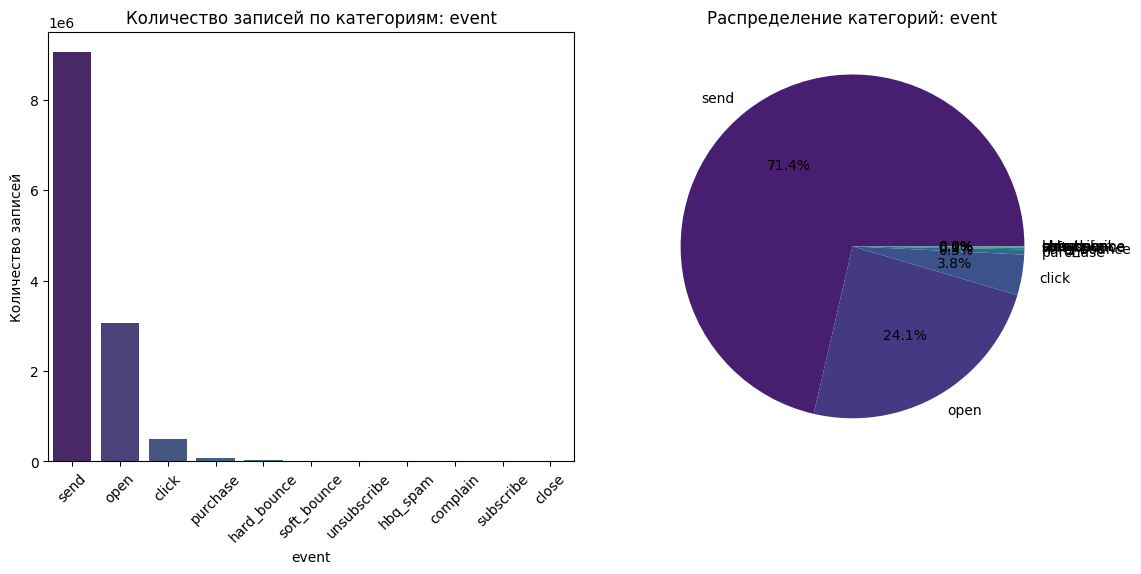


📚 Категориальный признак: channel (уникальных значений: 2)


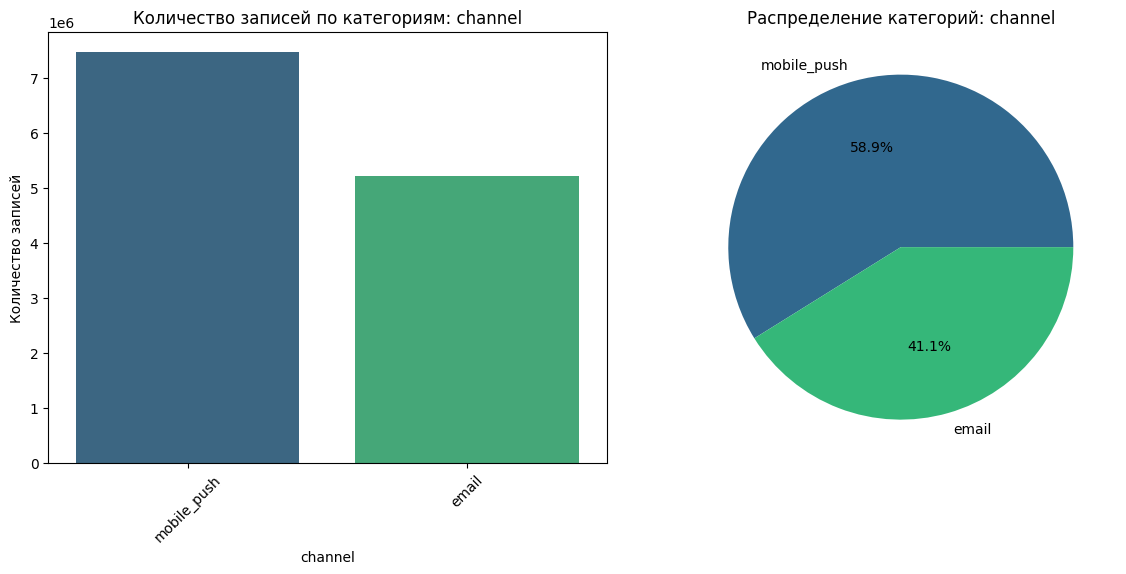


⚠️ Пропущен категориальный признак 'date' — слишком много уникальных значений (638).

⚠️ Пропущен категориальный признак 'created_at' — слишком много уникальных значений (4103539).


In [37]:
#построим гисторграммы и боксплот для всех числовых полей и столбчатую диаграмму для всех категориальных
plot_eda(messages, hist_bins=30, max_discrete_values=20, max_categories=300)

In [38]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Посмотрим детальнее агрегированную информацию по сообщениям:

In [39]:
messages.groupby('event')['message_id'].nunique().reset_index().sort_values(by='message_id', ascending=False)

,event,message_id
7,send,9055427
5,open,2912092
0,click,350058
6,purchase,49671
3,hard_bounce,19703
8,soft_bounce,10395
10,unsubscribe,2617
4,hbq_spam,823
2,complain,487
9,subscribe,82


In [40]:
messages.groupby(['channel', 'event'])['message_id'].nunique().reset_index().sort_values(by=['channel', 'message_id'], ascending=False)

,channel,event,message_id
15,mobile_push,send,5120881
13,mobile_push,open,2154783
10,mobile_push,click,117885
12,mobile_push,hard_bounce,19357
14,mobile_push,purchase,14651
16,mobile_push,soft_bounce,1016
11,mobile_push,close,1
6,email,send,3934546
4,email,open,757309
0,email,click,232173


Конверсия в покупку (по сообщениям):

In [41]:
# для пушей
messages.query('channel == "mobile_push" and event == "purchase"')['message_id'].nunique()/\
messages.query('channel == "mobile_push" and event == "send"')['message_id'].nunique()*100

0.2861031138977844

In [42]:
# для email
messages.query('channel == "email" and event == "purchase"')['message_id'].nunique()/\
messages.query('channel == "email" and event == "send"')['message_id'].nunique()*100

0.8900645716176656

In [43]:
messages.groupby(['channel', 'event'])['client_id'].nunique().reset_index().sort_values(by=['channel', 'client_id'], ascending=False)

,channel,event,client_id
15,mobile_push,send,36935
13,mobile_push,open,22907
10,mobile_push,click,21262
14,mobile_push,purchase,13071
12,mobile_push,hard_bounce,12473
16,mobile_push,soft_bounce,991
11,mobile_push,close,1
6,email,send,39051
4,email,open,37114
0,email,click,33289


Конверсию в покупку (по пользователям):

In [44]:
# для пушей
messages.query('channel == "mobile_push" and event == "purchase"')['client_id'].nunique()/\
messages.query('channel == "mobile_push" and event == "send"')['client_id'].nunique()*100

35.389197238391766

In [45]:
# для email
messages.query('channel == "email" and event == "purchase"')['client_id'].nunique()/\
messages.query('channel == "email" and event == "send"')['client_id'].nunique()*100

74.72023763796062

In [46]:
messages.groupby('channel')['message_id'].nunique()

channel
email          3939727
mobile_push    5121940
Name: message_id, dtype: int64

In [47]:
messages['created_at'].min()

Timestamp('2022-05-19 00:14:20')

In [48]:
messages['created_at'].max()

Timestamp('2024-02-15 23:58:40')

Вывод:\
Пушей отправляется чуть больше, чем email 58,9% против 41,1%. При этом конверсия в покупку в пушах ниже 0,29% против 0,89 у email.\
Если посмотреть по пользователям, с которыми была осуществлена коммуникация, то видим что рано или поздно после пушей покупает 35% пользователей, а после email 74%.\
Данные по рассылкам есть с мая 2022г по февраль 2024г.

## Покупки


📊 Дискретный числовой признак: quantity (уникальных значений: 16)


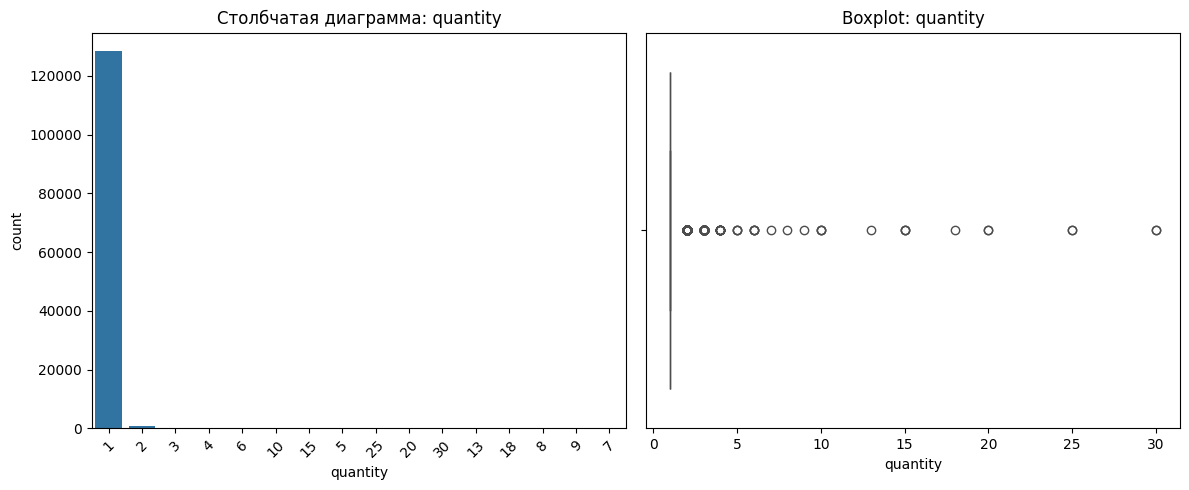


📈 Непрерывный числовой признак: price (уникальных значений: 3642)


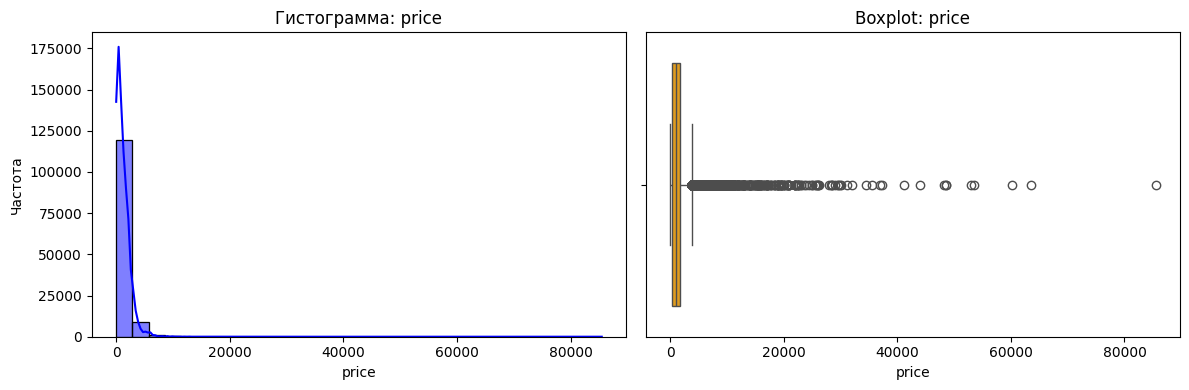


⚠️ Пропущен категориальный признак 'date' — слишком много уникальных значений (642).


In [49]:
#построим гисторграммы и боксплот для всех числовых полей и столбчатую диаграмму для всех категориальных
plot_eda(purchases, hist_bins=30, max_discrete_values=20, max_categories=300)

In [50]:
# вывдем статистическую информацию по числовым полям
purchases.describe()

,client_id,quantity,price
count,1.291880e+05,129188.000000,129188.000000
mean,1.515916e+18,1.009420,1264.532766
std,1.452553e+08,0.220332,1375.016339
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,399.000000
50%,1.515916e+18,1.000000,999.000000
75%,1.515916e+18,1.000000,1750.000000
max,1.515916e+18,30.000000,85499.000000


In [51]:
purchases['date'].min()

Timestamp('2022-05-16 00:00:00')

In [52]:
purchases['date'].max()

Timestamp('2024-02-16 00:00:00')

Вывод:\
Большинство пользователей покупают только один товар в заказе. Медианная стоимость товара 1750.\
Данные по покупкам есть с мая 2022г по февраль 2024г.

## Общий вывод

Пушей отправляется чуть больше, чем email 58,9% против 41,1%. При этом конверсия в покупку в пушах ниже 0,29% против 0,89 у email.\
Если посмотреть по пользователям, с которыми была осуществлена коммуникация, то видим что рано или поздно после пушей покупает 35% пользователей, а после email 74%.

Большинство пользователей покупают только один товар в заказе. Медианная стоимость товара 1750.

Данные по рассылкам и покупкам есть с мая 2022г по февраль 2024г.

# Подготовка фичей

В качестве времени отсчета (t0) 90 дней примем максимальную дату покупки в датафрейме с покупками.\
Фичи, которые будем использовать для обучения модели:
| Признак                    | Описание                                                                                          |
| -------------------------- | ------------------------------------------------------------------------------------------------- |
| `days_since_last_purchase` | Сколько дней назад клиент последний раз покупал (до `t0`)                                         |
| `n_purchases_90d`          | Сколько покупок было за последние 90 дней до `t0`                                                 |
| `monetary_90d`             | Общая сумма трат за 90 дней                                                                       |
| `avg_ticket`               | Средний чек по всем покупкам до `t0`                                                              |
| `n_unique_categories`      | Кол-во уникальных категорий, в которых покупал                                                    |
| `cat_44`, `cat_431`, ...   | Сколько раз покупал товары из этой категории (топ-100)                                            |
| `cat_other_cat`            | Сколько покупок не попали в топ-100                                                               |
| `n_messages_30d`           | Сколько сообщений получил за 30 дней до `t0`                                                      |
| `n_opens_30d`              | Сколько сообщений открыл                                                                          |
| `n_clicks_30d`             | Сколько сообщений кликнул                                                                         |
| `open_rate`                | `n_opens_30d / n_messages_30d`                                                                    |
| `click_rate`               | `n_clicks_30d / n_opens_30d`                                                                      |
| `days_since_last_open`     | Сколько дней прошло с последнего открытия письма                                                  |
| `max_event_level`          | Максимальный уровень взаимодействия (`0=sent`, `1=open`, `2=click`, `3=purchase`, `<0` — негатив) |
| `was_negative_event`       | Есть ли хотя бы одно негативное событие (`unsubscribe`, `complain`, `bounce`)                     |
| `target`                   | Целевой признак: купил ли в течение 90 дней после `t0`                                            |

In [53]:
def build_feature_target_df(purchases, messages, target_binary, df_top_n_cats):
    # Подготовка
    purchases = purchases.copy()
    messages = messages.copy()
    purchases['client_id'] = purchases['client_id'].astype(str)
    messages['client_id'] = messages['client_id'].astype(str)
    target_binary['client_id'] = target_binary['client_id'].astype(str)
    df_top_n_cats['client_id'] = df_top_n_cats['client_id'].astype(str)

    # Определяем t0 — дату отсчета
    t0 = purchases['date'].max()

    # Список клиентов
    clients = pd.DataFrame({'client_id': pd.Series(
        purchases['client_id'].tolist() + messages['client_id'].tolist()
    ).unique()})

    #  Покупки 
    p = purchases[purchases['date'] < t0].copy()
    p['days_since_purchase'] = (t0 - p['date']).dt.days
    p['is_90d'] = p['date'] >= (t0 - timedelta(days=90))
    p['cat_flat'] = p['category_ids'].apply(lambda x: list(set(x)))

    agg_purch = p.groupby('client_id').agg(
        days_since_last_purchase=('days_since_purchase', 'min'),
        n_purchases_90d=('is_90d', 'sum'),
        monetary_90d=('price', lambda x: x[p.loc[x.index, 'is_90d']].sum()),
        avg_ticket=('price', 'mean'),
        n_unique_categories=('cat_flat', lambda cats: len(set(cat for sub in cats for cat in sub)))
    ).reset_index()

    #  Рассылки 
    m = messages[messages['date'] < t0].copy()
    event_level = {
        'send': 0, 'sent': 0, 'open': 1, 'click': 2, 'purchase': 3,
        'unsubscribe': -1, 'complain': -2, 'hbq_spam': -2,
        'hard_bounce': -3, 'soft_bounce': -3, 'subscribe': 0
    }
    m['event_level'] = m['event'].map(event_level).fillna(-4)
    m['is_30d'] = m['date'] >= t0 - timedelta(days=30)
    m['is_open'] = m['event'] == 'open'
    m['is_click'] = m['event'] == 'click'

    negative_events = {'unsubscribe', 'complain', 'hbq_spam', 'hard_bounce', 'soft_bounce'}
    m['is_negative_event'] = m['event'].isin(negative_events)

    def last_open_days(x):
        opens = x[x['is_open']]
        if not opens.empty:
            return (t0 - opens['date'].max()).days
        else:
            return None

    agg_msg = m.groupby('client_id').apply(lambda group: pd.Series({
        'n_messages_30d': group['is_30d'].sum(),
        'n_opens_30d': group['is_open'].sum(),
        'n_clicks_30d': group['is_click'].sum(),
        'open_rate': group['is_open'].sum() / max(1, len(group)),
        'click_rate': group['is_click'].sum() / max(1, group['is_open'].sum()),
        'days_since_last_open': last_open_days(group),
        'max_event_level': group['event_level'].max(),
        'was_negative_event': group['is_negative_event'].any()
    })).reset_index()

    #  Объединение 
    df = clients.merge(agg_purch, on='client_id', how='left')
    df = df.merge(agg_msg, on='client_id', how='left')
    df = df.merge(target_binary, on='client_id', how='left')
    df = df.merge(df_top_n_cats, on='client_id', how='left')

    #  Обработка пропусков 
    fill_values = {
        'days_since_last_purchase': 999,
        'n_purchases_90d': 0,
        'monetary_90d': 0.0,
        'avg_ticket': 0.0,
        'n_unique_categories': 0,
        'n_messages_30d': 0,
        'n_opens_30d': 0,
        'n_clicks_30d': 0,
        'open_rate': 0.0,
        'click_rate': 0.0,
        'days_since_last_open': 999,
        'max_event_level': -4,
        'was_negative_event': False,
        'target': 0
    }
    for col in df.columns:
        if col.startswith('cat_'):
            fill_values[col] = 0

    df = df.fillna(fill_values)

    return df, t0

In [54]:
df_final, t0 = build_feature_target_df(purchases, messages, target_binary, df_cat)

In [55]:
df_final.head()

,client_id,days_since_last_purchase,n_purchases_90d,monetary_90d,avg_ticket,n_unique_categories,n_messages_30d,n_opens_30d,n_clicks_30d,open_rate,click_rate,days_since_last_open,max_event_level,was_negative_event,target,cat_other_cat,cat_27,cat_4,cat_260,cat_420,cat_28,cat_1828,cat_290,cat_422,cat_432,cat_244,cat_249,cat_615,cat_258,cat_441,cat_2,cat_18,cat_418,cat_239,cat_5562,cat_5630,cat_1848,cat_563,cat_5666,cat_5631,cat_6065,cat_6058,cat_6060,cat_57,cat_431,cat_275,cat_421,cat_155,cat_5549,cat_218,cat_212,cat_726,cat_5633,cat_124,cat_415,cat_213,cat_436,cat_44,cat_658,cat_673,cat_267,cat_440,cat_243,cat_425,cat_343,cat_312,cat_29,cat_505,cat_326,cat_31,cat_417,cat_5608,cat_561,cat_657,cat_62,cat_555,cat_5607,cat_146,cat_616,cat_274,cat_49,cat_656,cat_413,cat_17,cat_548,cat_500,cat_310,cat_434,cat_58,cat_104,cat_429,cat_1312,cat_340,cat_5589,cat_5597,cat_5536,cat_344,cat_445,cat_329,cat_506,cat_324,cat_38,cat_1822,cat_5632,cat_5537,cat_5963,cat_5959,cat_5634,cat_61,cat_466,cat_5683,cat_1431,cat_287,cat_661,cat_5669,cat_5548,total_cats,other_ratio
0,1515915625468169594,86.0,3.0,11859.0,2376.625000,15.0,15.0,125.0,13.0,0.488281,0.104000,3.0,3.0,False,0.0,3.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.09375
1,1515915625471138230,641.0,0.0,0.0,5499.000000,13.0,18.0,0.0,9.0,0.000000,9.000000,999.0,2.0,False,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.00000
2,1515915625471640575,609.0,0.0,0.0,1932.333333,12.0,29.0,79.0,21.0,0.194581,0.265823,3.0,3.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.00000
3,1515915625490211585,641.0,0.0,0.0,1699.000000,10.0,18.0,112.0,0.0,0.516129,0.000000,2.0,1.0,False,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50000
4,1515915625490739153,641.0,0.0,0.0,1999.000000,11.0,19.0,5.0,5.0,0.015198,1.000000,424.0,2.0,True,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.50000


In [56]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61196 entries, 0 to 61195
Columns: 118 entries, client_id to other_ratio
dtypes: bool(1), float64(116), object(1)
memory usage: 55.2+ MB


In [57]:
df_final['was_negative_event'] = df_final['was_negative_event'].astype(int)

# Корреляционный анализ признаков

In [58]:
def custom_plot_correlation_matrix(df, method='pearson', figsize=(10, 8), annot=True):
    # Исключаем столбцы, содержащие 'id'
    filtered_df = df[[col for col in df.columns if 'id' not in col.lower()]]
    # Выбираем только числовые признаки
    numeric_df = filtered_df.select_dtypes(include=['number'])
    
    # Проверяем, есть ли числовые признаки
    if numeric_df.empty:
        print("В DataFrame нет числовых признаков.")
        return
    
    # Расчёт матрицы корреляций
    correlation_matrix = numeric_df.corr(method=method)
    
    # Построение тепловой карты
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=annot, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.title(f'Матрица корреляций ({method})')
    plt.show()

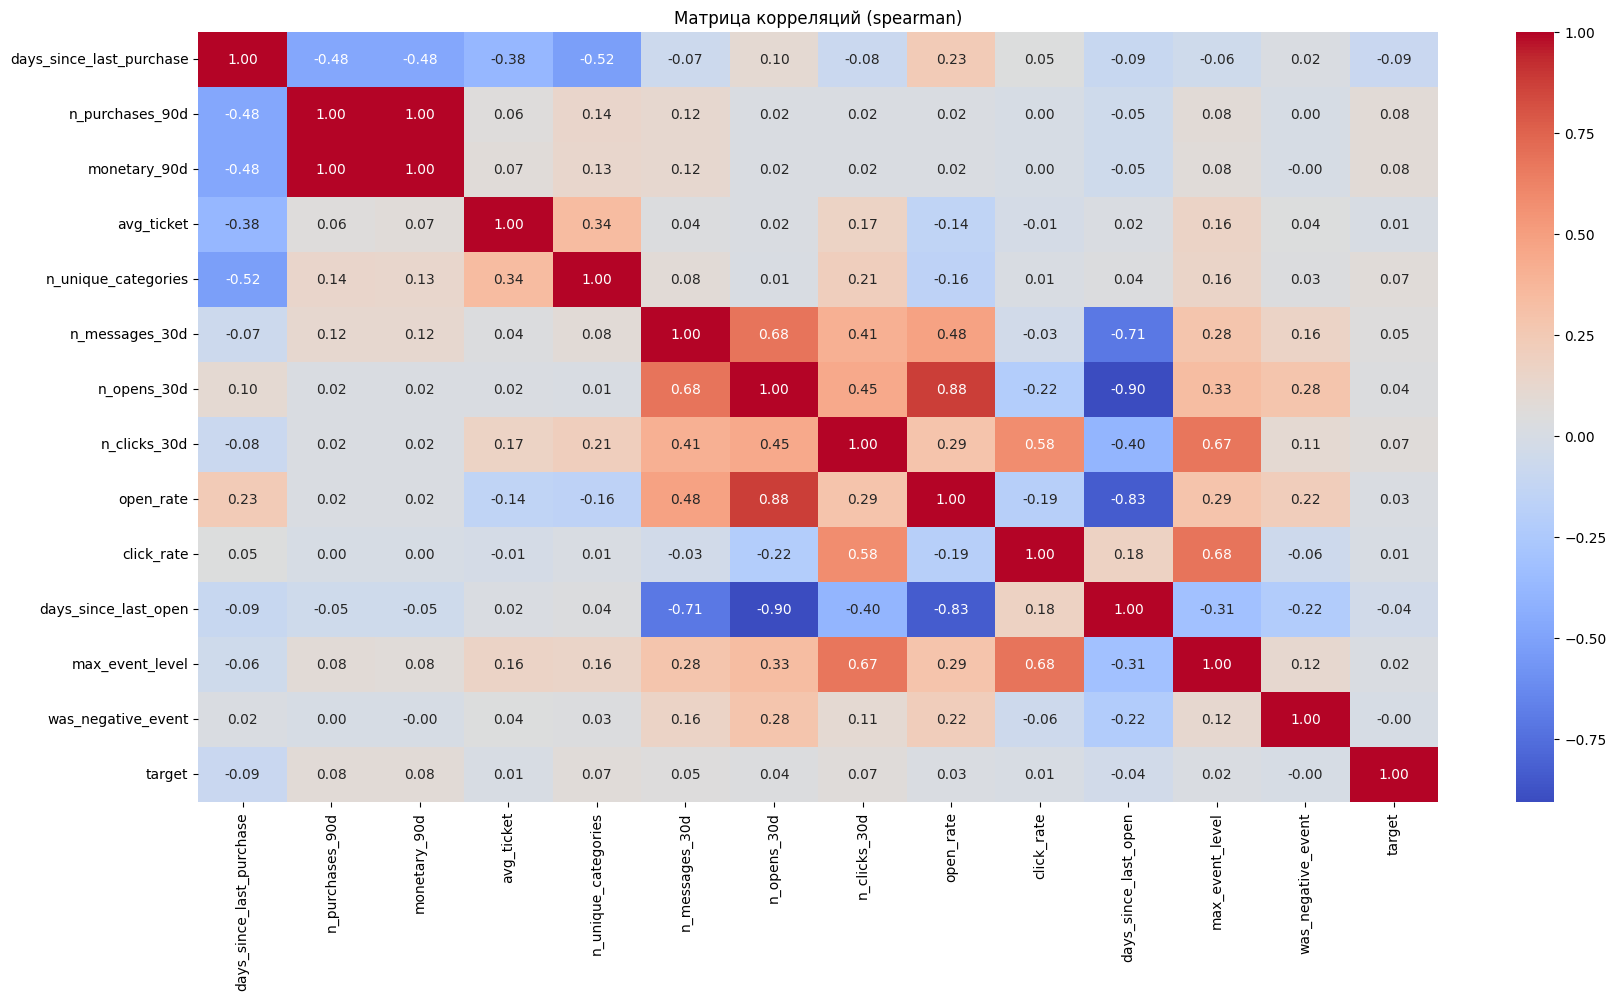

In [59]:
# т.к. данные распределены ненормально, то используем метод Спирмана
# из корреляционного анализа исключаем признаки, которые имеют слишком много уникальных значений и могу исказить результаты, 
custom_plot_correlation_matrix(df_final.iloc[:, :15], method='spearman', figsize=(20, 10), annot=True)

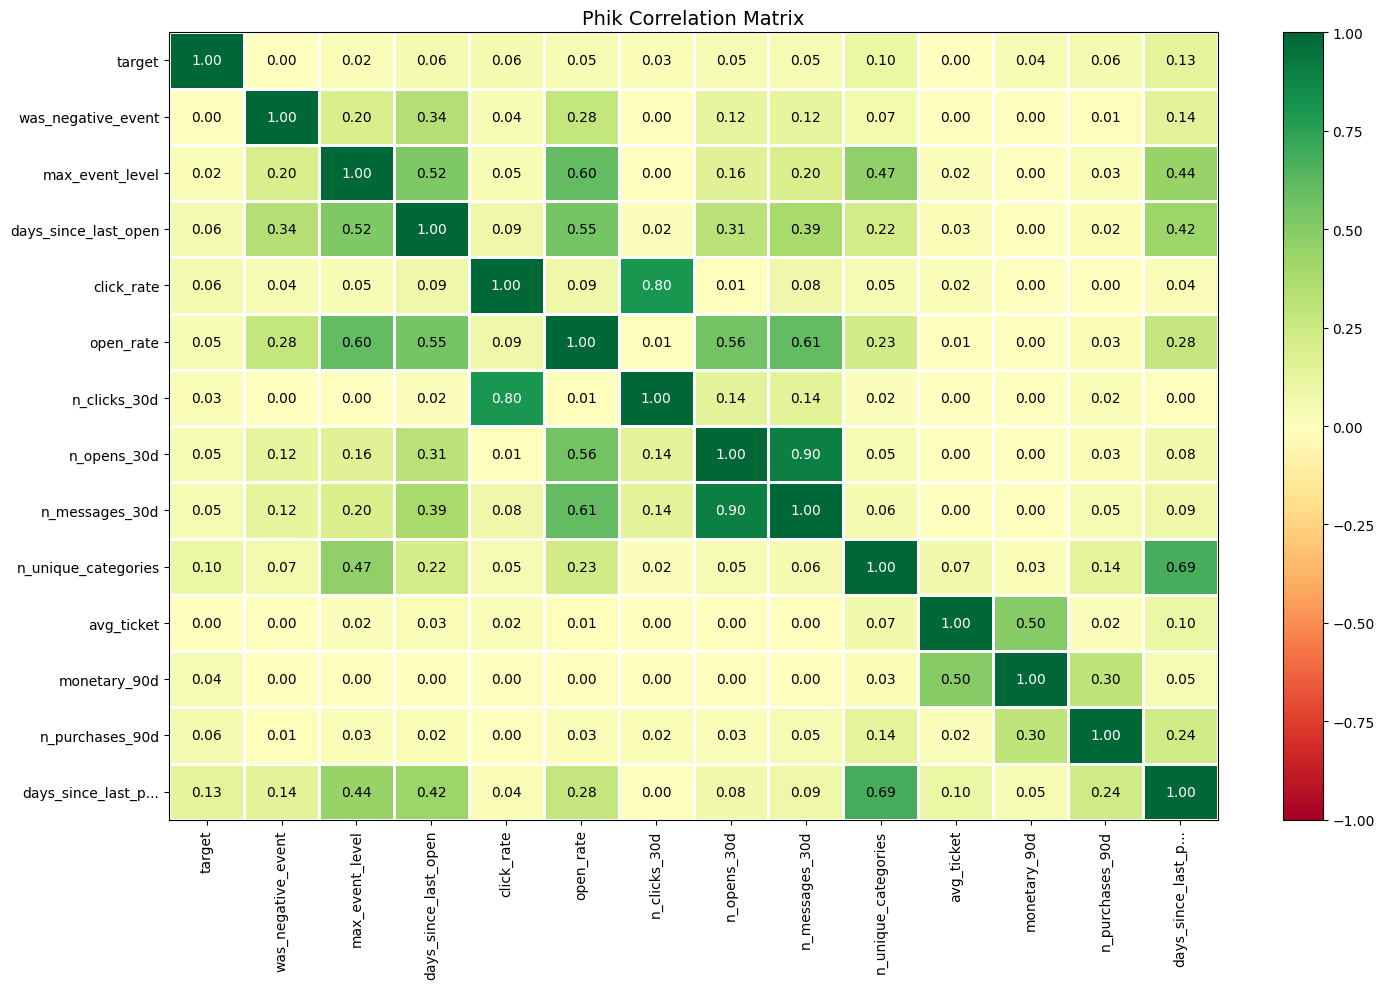

In [60]:
# проверим зависимость от всех признаков, в том числе категориальных, используя phik
columns_to_analyze = [col for col in df_final.iloc[:, :15].columns if 'id' not in col.lower() 
                      and 'name' not in col.lower()]

# определение непрерывных признаков
interval_cols = df_final.select_dtypes(include=['float', 'int']).columns
interval_cols = [col for col in interval_cols if df_final[col].nunique() > 20] 

phik_corr_matrix = df_final[columns_to_analyze].phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_corr_matrix.values,
                        x_labels=phik_corr_matrix.columns,
                        y_labels=phik_corr_matrix.index,
                        title="Phik Correlation Matrix",
                        figsize=(15, 10))
plt.show()

Вывод:\
1. Связь с target
| Признак                    | Корреляция с `target` | Комментарий                                                                                                    |
| -------------------------- | --------------------- | -------------------------------------------------------------------------------------------------------------- |
| `days_since_last_purchase` | **0.13**              | Наиболее информативный признак — чем меньше дней с момента последней покупки, тем выше шанс покупки в будущем. |
| `max_event_level`          | 0.02                  | Слабая положительная связь — возможно, те, кто взаимодействует более активно с письмами, склонны покупать.     |
| `open_rate`                | 0.05                  | Лёгкая положительная связь.                                                                                    |
| `click_rate`               | 0.06                  | Низкая, но чуть сильнее open\_rate — клики важнее открытий.                                                    |
| `n_unique_categories`      | 0.10                  | Мягкая связь — чем разнообразнее интересы пользователя, тем выше шанс покупки.                                 |
| `monetary_90d`             | 0.04                  | Была ли активность ранее — умеренный сигнал.                                                                   |
| `n_purchases_90d`          | 0.06                  | Согласуется с выше — покупки в прошлом = потенциальная покупка.                                                |
Все значения < 0.15 — прямая корреляция с target слаба, что типично при сильном дисбалансе классов
2. Взаимосвязи между признаками
| Пара                                               | Коэфф.   | Комментарий                                                                              |
| -------------------------------------------------- | -------- | ---------------------------------------------------------------------------------------- |
| `n_opens_30d` – `n_messages_30d`                   | **0.90** | Сильная зависимость — чем больше писем, тем больше открытий. Возможна избыточность.      |
| `open_rate` – `n_opens_30d`                        | **0.56** | Логично: open rate зависит от количества открытий.                                       |
| `click_rate` – `n_clicks_30d`                      | **0.80** | Те, кто много кликает, имеют высокий click rate.                                         |
| `days_since_last_open` – `max_event_level`         | **0.52** | Чем ближе последнее открытие, тем выше уровень взаимодействия.                           |
| `n_unique_categories` – `days_since_last_purchase` | **0.69** | Неочевидно — возможно, кто недавно покупал, интересовался большим количеством категорий. |


## Общий вывод

На основе матрицы корреляций для тренировочной выборки, можно сделать следующие выводы:

Видна достаточно сильная корреляция целеового признака и кол-ва дней существования компании, с остальными признаками корреляция слабая.\
Объем привлеченных инвестиций также коррелирует с кол-вом дней существований компании, кол-вом дней между первым и последним райндом финансирования и кол-вом раундов финансирования.\
При этом кол-во дней существования и между раундами коррелирует друг с другом.\
Корреляция между категориями стартаппов и другими признаками слабая. 

На тестовой выборке зависимости аналогичны, немного отличаются значения, но характер остается такой же как и на тренировочной, существенных различий не обнаружено. 

# Моделирование

Для выполнения задания будем решать задачу классификации, необходимо предсказать закроется компания или нет.\
Целевой признак - status.\
В качестве основной метрики примем F1-Score.

F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp). Полнота это отношение true positives ко всем actual positives (tp + fn).

## Модель

In [61]:
df_final.groupby('target')['client_id'].nunique()

target
0.0    60235
1.0      961
Name: client_id, dtype: int64

In [62]:
RANDOM_STATE = 42
TEST_SIZE    = 0.20
N_TRIALS     = 30   

In [63]:
X = df_final.iloc[:, :15].drop(columns=['client_id', 'target'])
y = df_final.iloc[:, :15]['target']

# p.s. 
# пробовал и с категориями, но они ничего не дают, только добавляют лишний шум в модель 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [65]:
#cat_cols  = X.select_dtypes('object').columns.tolist()        
bin_cols  = [c for c in X.columns if c.startswith('cat_')]   
num_cols  = [c for c in X.columns if c not in  bin_cols]  

Преобразование категориальных переменных выполним методом TargetEncoder, кросс-валидацию методом OptunaSearchCV:

In [66]:
bin_pipe = Pipeline([
    ('impute_bin', SimpleImputer(strategy='constant', fill_value=0))
])

# cat_pipe = Pipeline([
#     ('target_enc', TargetEncoder(cols=cat_cols, smoothing=0.2))
# ])

num_pipe = Pipeline([
    ('impute_num', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

num_pipe_gb = Pipeline([
    ('impute_num', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer([
    #('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols),
    ('bin', bin_pipe, bin_cols)
], remainder='drop')

preprocessor_gb = ColumnTransformer([
    ('num', num_pipe_gb, num_cols),
    ('bin', bin_pipe, bin_cols)
], remainder='drop')


base_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier())         
])

# --- 6.  ГИПЕРПАРАМЕТРЫ -------------------------------------------------------
param_dt = {
    'models':                optuna.distributions.CategoricalDistribution(
                              [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')]),
    'models__max_depth':     optuna.distributions.IntDistribution(2, 20),
    'models__max_features':  optuna.distributions.IntDistribution(1, len(num_cols)),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution(
                               [StandardScaler(), MinMaxScaler(), 'passthrough'])
}

param_knn = {
    'models':               optuna.distributions.CategoricalDistribution([KNeighborsClassifier()]),
    'models__n_neighbors':  optuna.distributions.IntDistribution(2, 20),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution(
                               [StandardScaler(), MinMaxScaler(), 'passthrough'])
}

param_lr_l1 = {
    'models': optuna.distributions.CategoricalDistribution([
        LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced',
                           random_state=RANDOM_STATE)
    ]),
    'models__C': optuna.distributions.FloatDistribution(1e-3, 1e3, log=True),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution(
                               [StandardScaler(), MinMaxScaler(), 'passthrough'])
}

param_lr_l2 = {
    'models': optuna.distributions.CategoricalDistribution([
        LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced',
                           max_iter=200, random_state=RANDOM_STATE)
    ]),
    'models__C': optuna.distributions.FloatDistribution(1e-3, 1e3, log=True),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution(
                               [StandardScaler(), MinMaxScaler(), 'passthrough'])
}

catboost_pipe = Pipeline([
    ('preprocessor', preprocessor_gb),
    ('models', CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)) #, loss_function='Logloss', border_count=128, auto_class_weights='SqrtBalanced
])

param_cat = {
    'models__iterations':         optuna.distributions.IntDistribution(200, 1000),
    'models__learning_rate':      optuna.distributions.FloatDistribution(0.01, 0.3),
    'models__depth':              optuna.distributions.IntDistribution(4, 10),
    'models__scale_pos_weight':   optuna.distributions.FloatDistribution(1, 30)
}

lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor_gb),
    ('models', LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', verbosity=-1))
])

param_lgbm = {
    'models__n_estimators':        optuna.distributions.IntDistribution(400, 1000),
    'models__learning_rate':       optuna.distributions.FloatDistribution(0.02, 0.15),
    'models__max_depth':           optuna.distributions.IntDistribution(-1, 10),
    'models__num_leaves':          optuna.distributions.IntDistribution(31, 127),
    'models__min_data_in_leaf':    optuna.distributions.IntDistribution(5, 30),
    'models__min_gain_to_split':   optuna.distributions.FloatDistribution(0.0, 0.001),
    'models__min_data_in_bin':     optuna.distributions.IntDistribution(1, 5),
    'models__feature_fraction':    optuna.distributions.FloatDistribution(0.6, 1.0),
    'models__bagging_fraction':    optuna.distributions.FloatDistribution(0.6, 1.0),
    'models__bagging_freq':        optuna.distributions.IntDistribution(0, 5)
}

# --- 7.  ПОМОЩНИК ДЛЯ ЗАПУСКА OPTUNA -----------------------------------------
def tune(pipeline, params):
    search = OptunaSearchCV(
        estimator           = pipeline,
        param_distributions = params,
        scoring             = 'roc_auc',
        #scoring             = 'f1',
        #scoring             = 'precision',
        cv                  = 5,
        n_trials            = N_TRIALS,
        random_state        = RANDOM_STATE,
        n_jobs              = 1,
        timeout             = 900
    )
    search.fit(X_train, y_train)
    return search

# --- 8.  ОБУЧАЕМ ВСЕ МОДЕЛИ ---------------------------------------------------
print("⏳ Hyper-parameter tuning…")
search_dt    = tune(base_pipe, param_dt)
search_knn   = tune(base_pipe, param_knn)
search_lr_l1 = tune(base_pipe, param_lr_l1)
search_lr_l2 = tune(base_pipe, param_lr_l2)
search_cat   = tune(catboost_pipe,  param_cat)
search_lgbm  = tune(lgbm_pipe, param_lgbm)

# --- 9.  ФУНКЦИЯ ОТЧЁТА -------------------------------------------------------
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def report(name, model):
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} ===")
    print("  best ROC AUC (CV):", model.best_score_)
    print("  ROC AUC (test):   ", roc_auc_score(y_test, y_proba))
    print("  F1-score:         ", f1_score(y_test, y_pred))
    print("  Precision:        ", precision_score(y_test, y_pred))
    print("  Recall:           ", recall_score(y_test, y_pred))
    print("  Accuracy:         ", accuracy_score(y_test, y_pred))
    print("  best params:      ", model.best_params_)

# --- 10.  ВЫВОДИМ РЕЗУЛЬТАТЫ --------------------------------------------------
report("DecisionTree", search_dt)
report("KNN",          search_knn)
report("LogReg L1",    search_lr_l1)
report("LogReg L2",    search_lr_l2)
report("CatBoost",     search_cat)
report("LightGBM",     search_lgbm)

# --- 11.  ЛУЧШАЯ МОДЕЛЬ -------------------------------------------------------
best = max(
    [search_dt, search_knn, search_lr_l1, search_lr_l2, search_cat, search_lgbm],
    key=lambda m: m.best_score_
)

print(f"\n🏆 Лучшая модель по mean ROC AUC (CV): {best.estimator.steps[-1][1].__class__.__name__}")
print("ROC AUC (test):", roc_auc_score(y_test, best.predict_proba(X_test)[:, 1]))

[I 2025-05-21 06:51:08,610] A new study created in memory with name: no-name-ef811ba5-1b34-46b3-89db-fe7cbc96c6c9


⏳ Hyper-parameter tuning…


[I 2025-05-21 06:51:10,284] Trial 0 finished with value: 0.6318739862345059 and parameters: {'models': DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=11,
                       random_state=42), 'models__max_depth': 10, 'models__max_features': 11, 'preprocessor__num__scale': 'passthrough'}. Best is trial 0 with value: 0.6318739862345059.
[I 2025-05-21 06:51:11,026] Trial 1 finished with value: 0.7062600596599188 and parameters: {'models': DecisionTreeClassifier(class_weight='balanced', max_depth=7, max_features=3,
                       random_state=42), 'models__max_depth': 7, 'models__max_features': 3, 'preprocessor__num__scale': 'passthrough'}. Best is trial 1 with value: 0.7062600596599188.
[I 2025-05-21 06:51:12,687] Trial 2 finished with value: 0.6793770827563692 and parameters: {'models': DecisionTreeClassifier(class_weight='balanced', max_depth=8, max_features=13,
                       random_state=42), 'models__max_depth': 8, 'models__max_features'


=== DecisionTree ===
  best ROC AUC (CV): 0.7377824092848403
  ROC AUC (test):    0.7372960415283311
  F1-score:          0.060698689956331875
  Precision:         0.03167730173199635
  Recall:            0.7239583333333334
  Accuracy:          0.6485294117647059
  best params:       {'models': DecisionTreeClassifier(class_weight='balanced', max_depth=3, max_features=12,
                       random_state=42), 'models__max_depth': 4, 'models__max_features': 9, 'preprocessor__num__scale': MinMaxScaler()}

=== KNN ===
  best ROC AUC (CV): 0.6321469364248273
  ROC AUC (test):    0.623727961418216
  F1-score:          0.0
  Precision:         0.0
  Recall:            0.0
  Accuracy:          0.984313725490196
  best params:       {'models': KNeighborsClassifier(n_neighbors=12), 'models__n_neighbors': 20, 'preprocessor__num__scale': StandardScaler()}

=== LogReg L1 ===
  best ROC AUC (CV): 0.7688869054903448
  ROC AUC (test):    0.7750616457779992
  F1-score:          0.0662029263612377
 

Посмотрим на precision - recall кривую и посмотрим какой может быть оптимальный порог вероятности покупки для максимизации метрик:

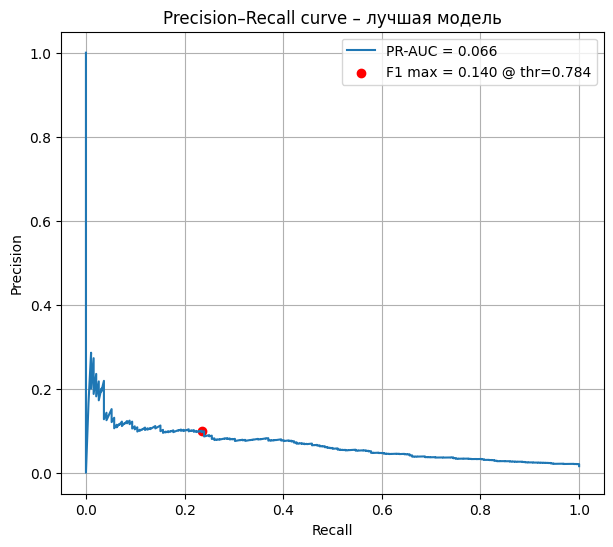

Лучший порог = 0.784;  Precision = 0.100;  Recall = 0.234


In [67]:
from sklearn.metrics import precision_recall_curve, auc, f1_score

# 1. вероятности лучшей модели
y_proba = best.predict_proba(X_test)[:, 1]

# 2. точки кривой
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# 3. максимальный F1
f1 = 2 * precision * recall / (precision + recall + 1e-9)
best_idx = np.argmax(f1)
best_thr = thresholds[best_idx]
best_f1  = f1[best_idx]

# 4. график
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f}')
plt.scatter(recall[best_idx], precision[best_idx],
            marker='o', color='red',
            label=f'F1 max = {best_f1:.3f} @ thr={best_thr:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall curve – лучшая модель')
plt.legend()
plt.grid(True)
plt.show()

print(f'Лучший порог = {best_thr:.3f};  Precision = {precision[best_idx]:.3f};  Recall = {recall[best_idx]:.3f}')

Вывод:\
Целью моделирования было построение модели, максимально эффективно предсказывающей целевое событие, при этом ключевой метрикой оценки выступает ROC AUC.

🔹 Лучшие результаты по ROC AUC на тестовой выборке показали:

LightGBM: 0.7889

CatBoost: 0.7881

LogReg L2: 0.7764

LogReg L1: 0.7751

🔹 По среднему значению ROC AUC при кросс-валидации (CV):

Победителем является LightGBM с 0.7793

Второе место — CatBoost (0.7748)

Дополнительные наблюдения:
CatBoost показал наилучший компромисс между ROC AUC и F1-мерой (0.126), что говорит о лучшем балансе между precision и recall при достаточно высокой общей точности (0.93). Однако recall был сравнительно низким (0.31).

Логистическая регрессия (L1 и L2) обеспечила высокий recall (~0.72), что может быть полезно в задачах, где важен захват положительных случаев, но при этом precision был низким (~0.035), что указывает на большое количество ложных срабатываний.

KNN оказался неконкурентоспособным — нулевые значения F1, precision и recall говорят о неспособности модели корректно идентифицировать положительный класс при несбалансированных данных.

Decision Tree продемонстрировал умеренный результат: ROC AUC около 0.737, но низкий precision (0.0317), несмотря на высокий recall (0.724).

Рекомендации:\
LightGBM — наиболее предпочтительная модель, показывающая лучшее качество по основной метрике как на кросс-валидации, так и на тесте. Рекомендуется использовать её в продакшн-решении.

CatBoost может использоваться как альтернатива, особенно если важен precision (например, для ограничения количества ложноположительных срабатываний).

## Проверка модели на адекватность

In [68]:
# Проверим модель на адекватность при помощи DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

dummy_pred = dummy_clf.predict(X_train)
dummy_proba = dummy_clf.predict_proba(X_train)[:, 1]

dummy_auc = roc_auc_score(y_train, dummy_proba)
dummy_acc = accuracy_score(y_train, dummy_pred)
dummy_precision = precision_score(y_train, dummy_pred, zero_division=0)
dummy_recall = recall_score(y_train, dummy_pred, zero_division=0)
dummy_f1 = f1_score(y_train, dummy_pred, zero_division=0)


print("Метрики для DummyClassifier:")
print(f"ROC AUC:    {dummy_auc:.4f}")
print(f"Accuracy:   {dummy_acc:.4f}")
print(f"Precision:  {dummy_precision:.4f}")
print(f"Recall:     {dummy_recall:.4f}")
print(f"F1-score:   {dummy_f1:.4f}")

Метрики для DummyClassifier:
ROC AUC:    0.5000
Accuracy:   0.9843
Precision:  0.0000
Recall:     0.0000
F1-score:   0.0000


Полученные метрики модели существенно лучше, чем рандомные.

## Анализ важности признаков

In [69]:
lgbm_model = search_lgbm.best_estimator_.named_steps['models']

<Figure size 1000x800 with 0 Axes>

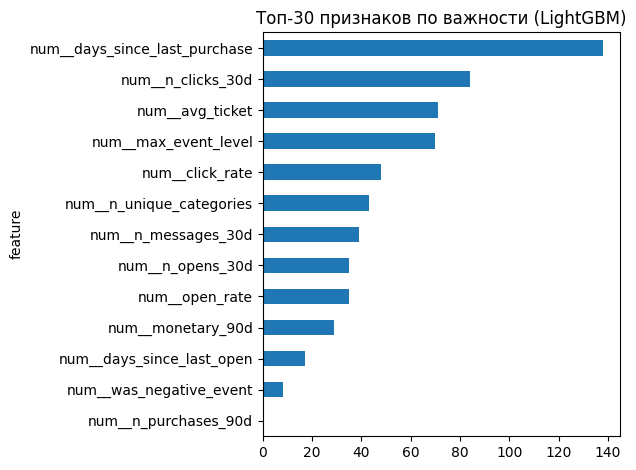

In [70]:
# 1. Названия признаков после препроцессинга
X_transformed = search_lgbm.best_estimator_.named_steps['preprocessor'].transform(X_test)
feature_names = search_lgbm.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# 2. Важности
importances = lgbm_model.feature_importances_

# 3. Таблица важностей
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 4. Топ-30 на графике
plt.figure(figsize=(10, 8))
feat_imp.head(30).plot(kind='barh', x='feature', y='importance', legend=False)
plt.title("Топ-30 признаков по важности (LightGBM)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 98%|===================| 11987/12240 [00:41<00:00]        

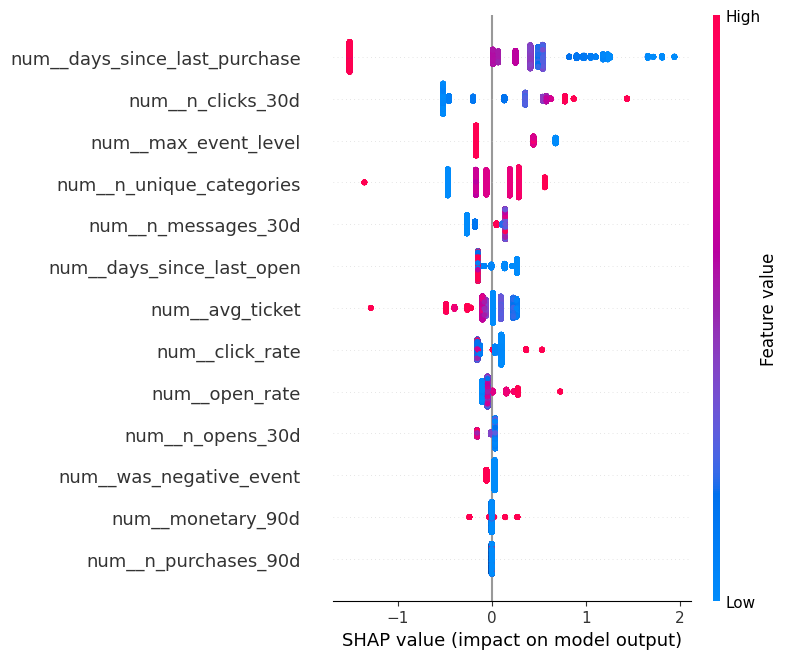

In [71]:
import shap

explainer = shap.Explainer(lgbm_model, X_transformed)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

Вывод:\
| Признак                                  | Интерпретация SHAP                                                                           |
| ---------------------------------------- | -------------------------------------------------------------------------------------------- |
| `days_since_last_purchase`               | **Чем меньше значение**, тем **сильнее толкает к покупке** (вправо). Всё ожидаемо. |
| `n_clicks_30d`                           | Большое количество кликов  **сильно повышает вероятность** покупки.                 |
| `max_event_level`                        | Высокие значения синжают вероятность покупки, неинтуитивно, но может быть                                                      |
| `n_unique_categories`                    | Больше разнообразия → чаще «плюс к покупке».                                                 |
| `avg_ticket`                             | Чем меньше чек, тем выше вероятность новой покупки. В целом логично, т.к. мелкие покупки делают чаще.                |
| `days_since_last_open`, `n_messages_30d` | В целом эффект слабый, но работает в комплексе.                                              |
| `was_negative_event`, `n_purchases_90d`  | SHAP-полосы узкие, точек мало — **почти не влияют**. Модель на них не опирается.             |


## Итоговая таблица вероятностей покупки в следующие 90 дней

In [72]:
client_ids = df_final['client_id']

In [73]:
best_model = best.best_estimator_
proba = best_model.predict_proba(X_test)[:, 1] 

In [74]:
best_model        = best.best_estimator_          
y_proba_full      = best_model.predict_proba(X)[:, 1]   

# 3. Датафрейм с результатом
df_all_predictions = (
    pd.DataFrame({'client_id': client_ids.values,
                  'purchase_probability': y_proba_full})
      .sort_values(by='purchase_probability', ascending=False)
      .reset_index(drop=True)
)

In [75]:
df_all_predictions.head()

,client_id,purchase_probability
0,1515915625589636242,0.975997
1,1515915625484938025,0.973592
2,1515915625468200785,0.973289
3,1515915625566604535,0.970682
4,1515915625468159950,0.966644


In [76]:
df_all_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61196 entries, 0 to 61195
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             61196 non-null  object 
 1   purchase_probability  61196 non-null  float64
dtypes: float64(1), object(1)
memory usage: 956.3+ KB


# Общий вывод по проекту

Цель проекта
Определить пользователей, готовых совершить покупку в ближайшие 90 дней, для повышения эффективности рассылок и планирования продаж в интернет-магазине.

1. Описание данных\
В проекте использованы три ключевых источника данных:

История покупок: информация о заказах (дата, категории, количество, цена, ID клиента и сообщения).

История рассылок: данные об email/push-коммуникациях (дата, канал, действия пользователя).

Целевой признак: совершил ли пользователь покупку в течение 90 дней после контрольной даты (target).

2. Предобработка\
Обработаны типы данных (даты).

Удалены дубликаты.

Проверены и очищены аномальные значения в price и quantity.

Категориальные признаки по категориям товаров были закодированы, но исключены из финального моделирования — они оказались неинформативными.

3. Исследовательский анализ\
Push-рассылки преобладают по объему (58.9%), но уступают email-каналу по эффективности:

конверсия в покупку: push — 0.29%, email — 0.89%;

покупают после коммуникации: push — 35%, email — 74%.

Типичный чек: медианное значение — 1750₽.

Одна покупка — стандарт: большинство клиентов заказывают один товар за раз.

4. Подготовка фичей
Выделены признаки, отражающие:

Покупательскую активность: частота, сумма, средний чек, разнообразие категорий.

Поведение в рассылках: открытие, клики, негативные события, отклик.

Временные отрезки: сколько времени прошло с последней покупки/взаимодействия.

Целевая дата (t0) выбрана как максимальная дата покупки — прогноз осуществляется на 90 дней вперёд от этой точки.

5. Корреляционный анализ
Самые информативные признаки:

days_since_last_purchase — корреляция с target: 0.13

n_unique_categories, click_rate, n_purchases_90d — слабая, но положительная связь

Между признаками обнаружены ожидаемые зависимости (например, между количеством сообщений и открытий), что было учтено при отборе фичей.

6. Моделирование
Модели обучались с учетом дисбаланса классов, основная метрика — ROC AUC.
| Модель       | ROC AUC (CV) | ROC AUC (Test) | F1-score | Precision | Recall | Accuracy |
| ------------ | ------------ | -------------- | -------- | --------- | ------ | -------- |
| **LightGBM** | 0.7793       | **0.7889**     | 0.0703   | 0.0370    | 0.703  | 0.7082   |
| CatBoost     | 0.7748       | 0.7881         | 0.1260   | 0.0790    | 0.313  | 0.9320   |
| LogReg (L2)  | 0.7694       | 0.7764         | 0.0678   | 0.0356    | 0.719  | 0.6901   |
| LogReg (L1)  | 0.7689       | 0.7751         | 0.0662   | 0.0347    | 0.719  | 0.6819   |
| DecisionTree | 0.7378       | 0.7373         | 0.0607   | 0.0317    | 0.724  | 0.6485   |
| KNN          | 0.6321       | 0.6237         | 0.0000   | 0.0000    | 0.000  | 0.9843   |

Лучшая модель: LightGBM — показала наивысший ROC AUC и стабильные результаты на кросс-валидации и тесте.

7. Интерпретация модели (SHAP)\
Самые важные признаки:

days_since_last_purchase — чем ближе покупка, тем выше шанс новой.

n_clicks_30d — активные пользователи в рассылках склонны к покупкам.

avg_ticket — пользователи с низким средним чеком чаще покупают повторно.

Признаки взаимодействия с рассылками работают, но не являются ключевыми по одиночке — важен комплексный поведенческий портрет.

8. Финальный результат\
Сформирован датафрейм с client_id и вероятностью покупки, который можно использовать:

для таргетинга маркетинговых кампаний;

для оптимизации коммуникаций по каналам;

для оценки вероятности LTV в перспективе.

**Рекомендации**\
Использовать модель LightGBM в продуктивной среде, обновляя обучающую выборку по мере накопления данных.

Протестировать альтернативные стратегии таргетинга на основе прогноза: приоритизация каналов, частоты и содержания сообщений.

Рассмотреть внедрение онлайн-обновления модели или переобучения раз в квартал.

In [77]:
#pip freeze > "C:\Users\bondarev\Documents\DS study\data\ms_2\requirements.txt"

Note: you may need to restart the kernel to use updated packages.
